# 🙋‍♂️ Preamble 🙋‍♂️ #

Name : Ayoub Choukri

Date : 25 November 2023

Subject : Mall Customer Segmentation with Clustering

**🤞Note🤞** : This notebook is a part of a series of notebooks that I will be publishing on my [Github]() and [Kaggle]() accounts. Please feel free to check them out and give me your feedback.

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn
import pandas as pd
import sklearn as sk
import statsmodels.api as sm
from mca import *

# 🛍️ General Context 🛍️

Mall Customer Segmentation is a very common problem in the retail industry. It is a very important task that helps the marketing team to better understand their customers and to better target them with the right products and services. In this notebook, we will be using different clustering algorithms to segment the customers of a mall based on different criterias, like Customer ID, Age, Gender, Annual Income and Spending Score.



<p align="center">
  Let's Go shopping 🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️
</p>

<p align="center">
  <img src="https://media.tenor.com/Rryy7bbslUYAAAAC/shopping-goose.gif" alt="Shopping Goose">
</p>

# 📊 Importing The Data Set 📊

In [11]:
data = pd.read_csv("./Data/Mall_Customers.csv")
pd.set_option('display.max_columns',None)
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

# 🧹Data Preprocessing🧹

Let's take a look to ou DataSet

In [12]:
display(data.sample(5))
data.shape

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
126,127,Male,43,71,35
179,180,Male,35,93,90
17,18,Male,20,21,66
80,81,Male,57,54,51
109,110,Male,66,63,48


(200, 5)

> We notice that our DataSet contains $200$ rows (Customers) and $5$ Columns :
>
>  **`CustomerID`** : The ID of the customer
> 
>  **`Gender`** : The Gender of the customer
> 
>  **`Age`** : The Age of the customer
> 
>  **`Annual Income`** : The Annual Income of the customer
> 
>  **`Spending Score`** : The Spending Score of the customer

> The Spending Score of a customer is a score that the mall assigns to each customer based on their purchasing behavior and purchasing data.

Let's put each variable in its right dtype

In [13]:
df=data.copy()
categorical_columns = ['CustomerID','Gender']
numerical_columns=['Age','Annual Income (k$)','Spending Score (1-100)']


In [14]:
df[categorical_columns] = df[categorical_columns].astype('category')
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric, errors='coerce')

## Missing Values

<Axes: >

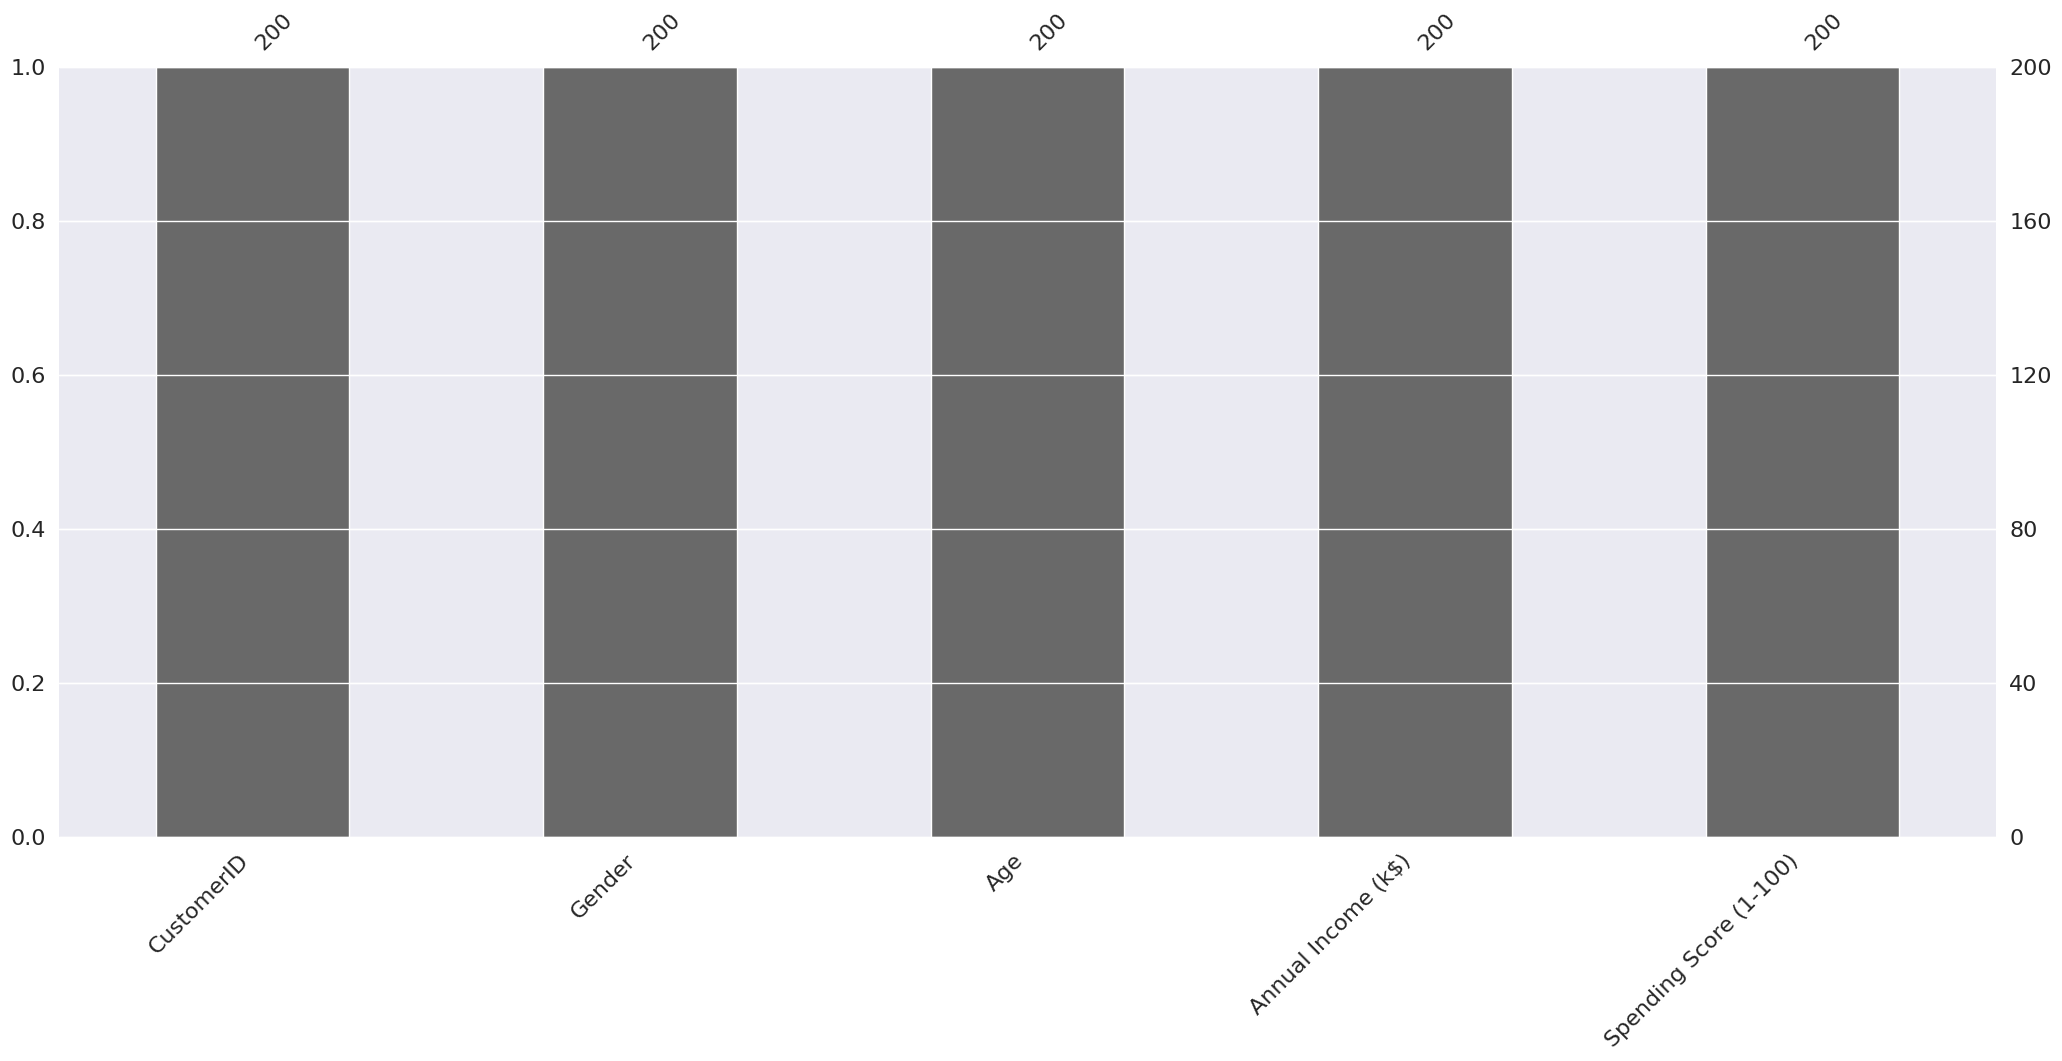

In [15]:
msn.bar(df)

We see that our dataset doesn't contain any missing values.

# 📊📈 Descriptive Analysis📊📈

### Boxplots and Outliers

Text(0.5, 1.0, 'Box plot of numerical columns')

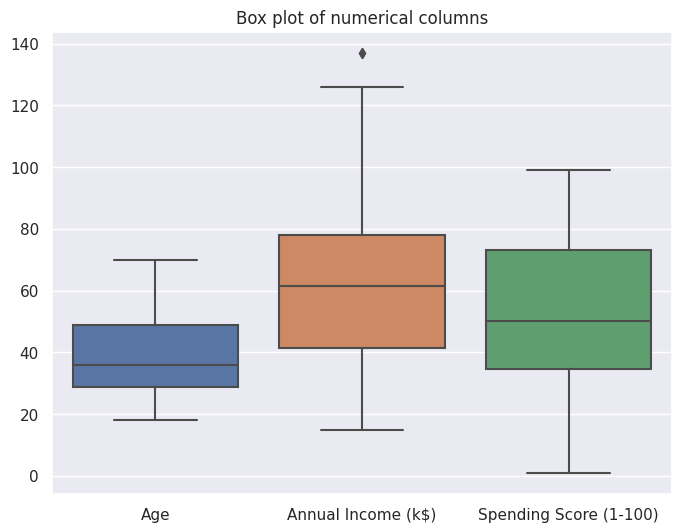

In [16]:
plt.figure(figsize=(8,6))
i=sns.boxplot(data[numerical_columns])
plt.title("Box plot of numerical columns")

> We notice that the different boxplots are well distributed.
> 
> We can easily distinguish the different quartiles of the different variables.. For instance, the variable Age, is a little bit assymetric (skewed to the right).
>
> The different variables have almost the same variance.

> Considering the fact that our variable have different dimensions, we will try to scale the Data.

>Finally, we notice that our dataset doesn't contain any outliers. 

In [17]:
df_scaled = df.copy()
df_scaled[numerical_columns]=(df_scaled[numerical_columns]-df_scaled[numerical_columns].mean())/df_scaled[numerical_columns].std()

Text(0.5, 1.0, 'Box plot of numerical columns')

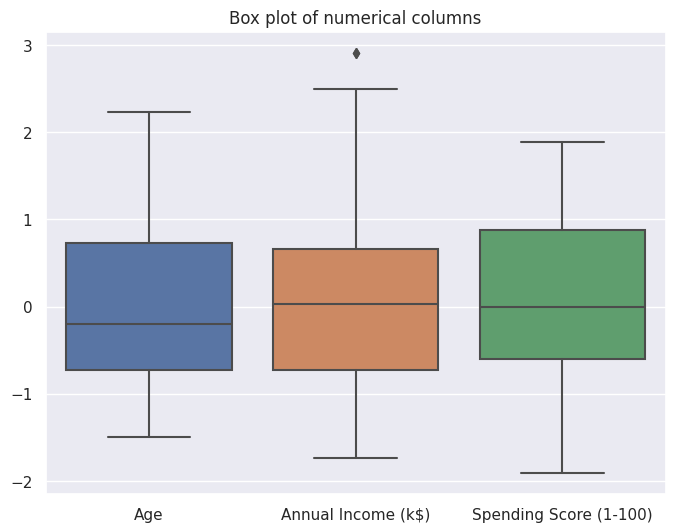

In [18]:
plt.figure(figsize=(8,6))
i=sns.boxplot(df_scaled[numerical_columns])
plt.title("Box plot of numerical columns")

We notice that the boxplots didn't change alot after scaling the data.

## 🔢📏 Quantitative Variables🔢📏

### Densities

I will estimate the density of the numerical columns using the kernel density estimation method.

In [19]:
def density(data,plot_variables,size,color,l,c,nmax=None):
    fig, axes = plt.subplots(l,c,figsize=size)
    if min(l,c)>1:
        for i in range(l):
            for j in range(0,c):
                sns.kdeplot(data[plot_variables[c*i+j]],ax=axes[i,j],color=color,fill=True)
                axes[i,j].set_title(f"Density plot of {plot_variables[c*i+j]}")
    elif min(l,c)==1:
        for i in range(len(plot_variables)):
            sns.kdeplot(data[plot_variables[i]],ax=axes[i],color=color,fill=True)
            axes[i].set_title(f"Density plot of {plot_variables[i]}")



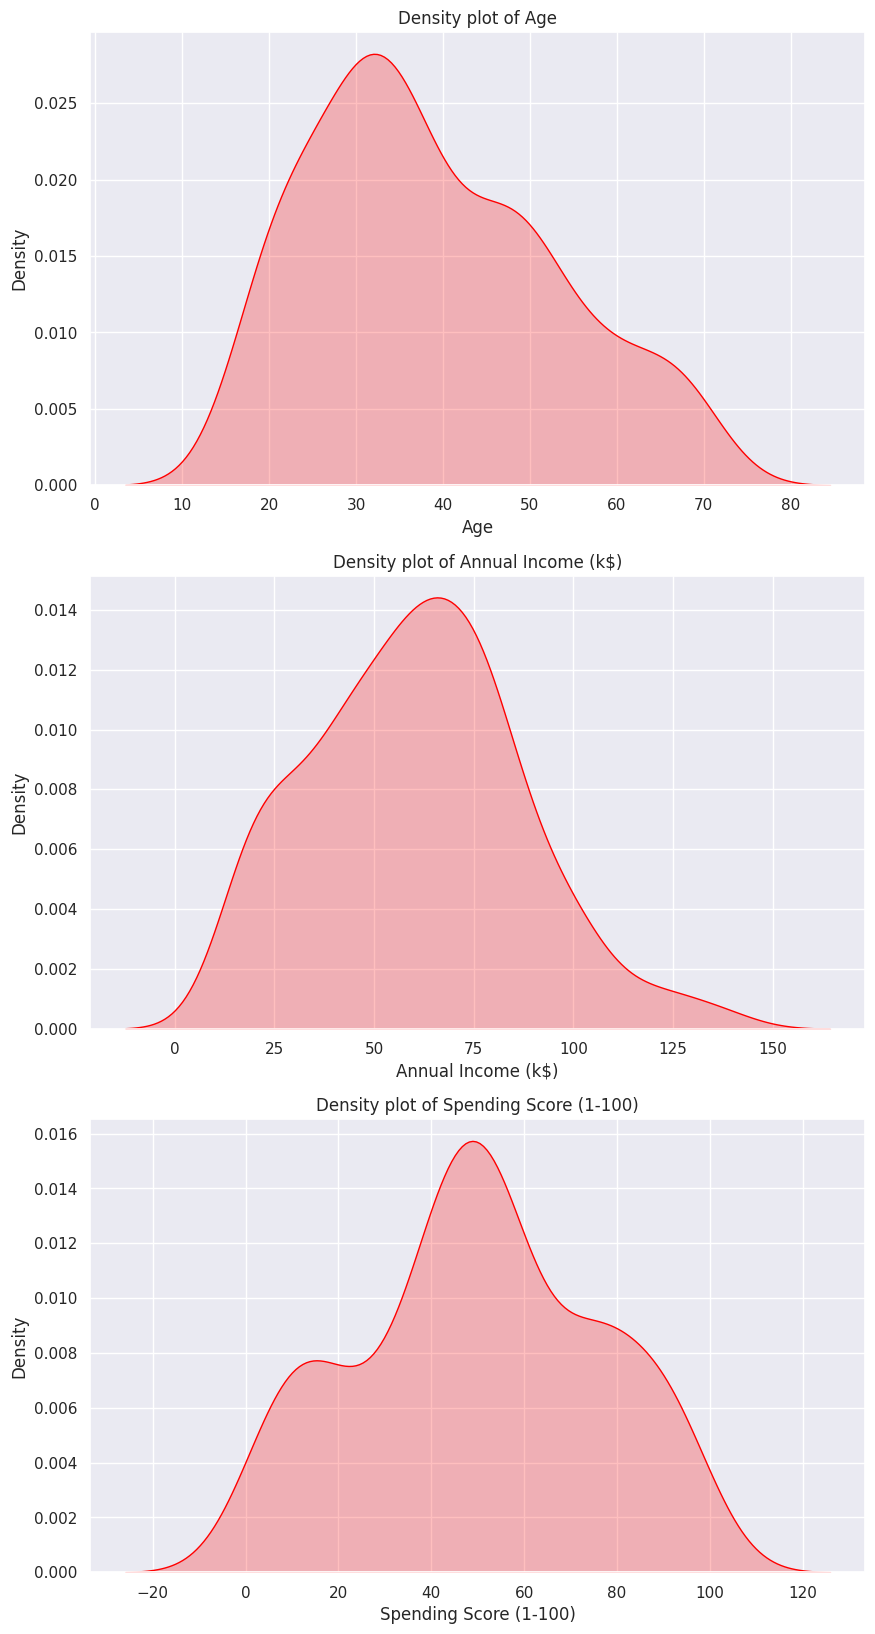

In [20]:
density(df,numerical_columns,(10,20),'red',3,1)

## 🔤Qualitative Variables🔤

Text(0.5, 1.0, 'Count plot of Pizza Brands')

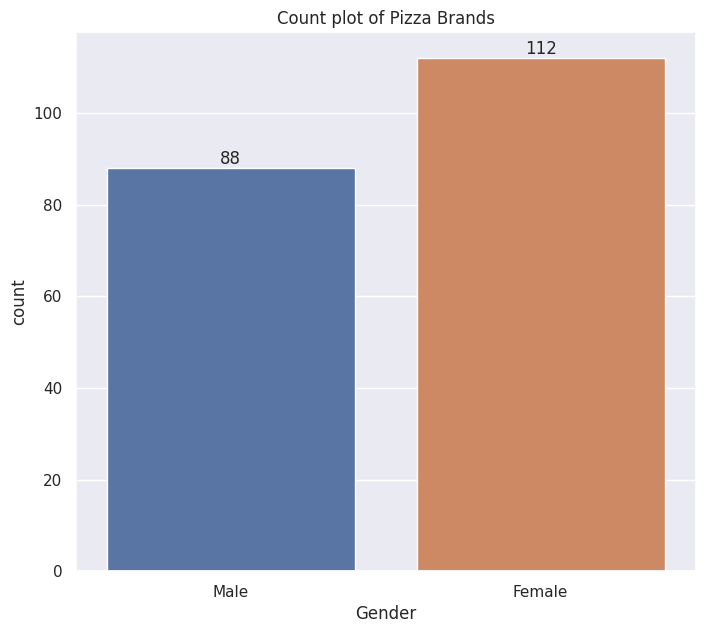

In [21]:
fig,ax=plt.subplots(1,1,figsize=(8,7))
sns.countplot(data=data,x='Gender',axes=ax)
ax.bar_label(ax.containers[0],label_type='edge')
ax.set_title("Count plot of Pizza Brands")

We can see that $112$ of the customers are Female and $88$ are Males

## 🔄📊Bi-Variate Analysis🔄📊

### Correlation Matrix

<Axes: >

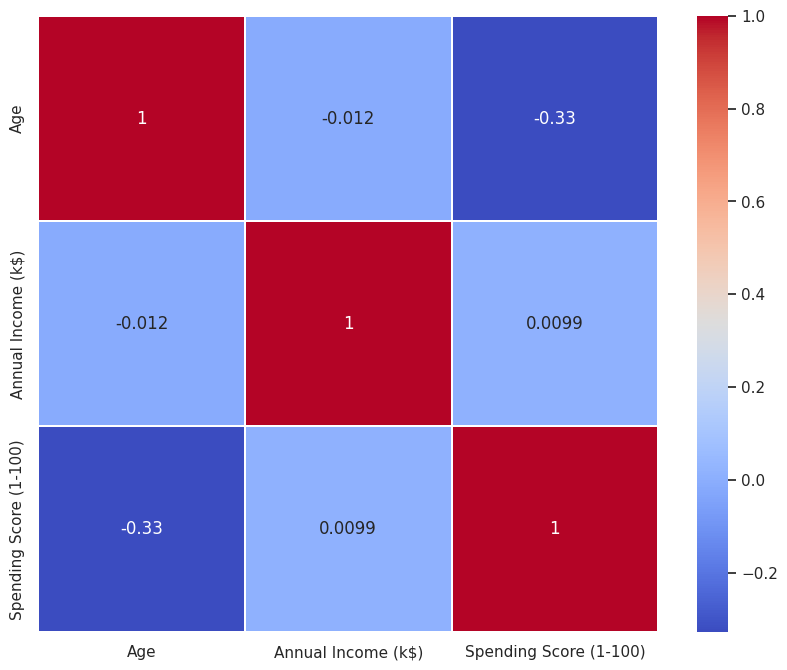

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.2)

> We can notice that there is no strong correlation between the different variables. Indeed, it is expected that the variables are not correlated. For example, the Annual Income of a customer is not correlated to the Age. 

> However, the correlation matrix shows that there is no strong lineal relationship between the Spending Score and the Annual Income of the customers nor the Age of the customers.

### Pairplot

Text(0.5, 1.02, 'Pairplot of numerical columns colored by Gender')

<Figure size 1000x800 with 0 Axes>

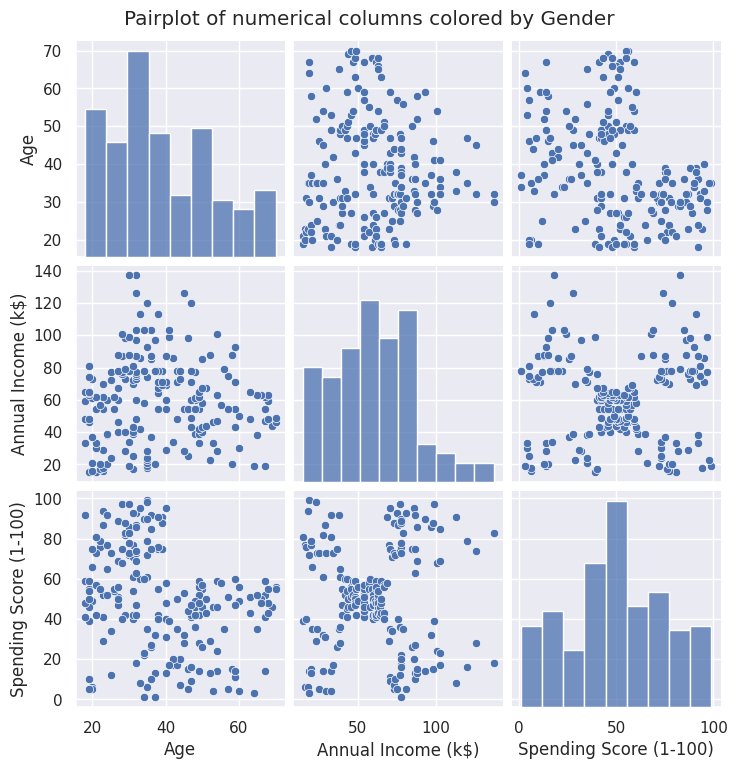

In [23]:
plt.figure(figsize=(10,8))
sns.pairplot(df,vars= numerical_columns,palette='tab20')
plt.suptitle("Pairplot of numerical columns colored by Gender", y=1.02)

We can see that we can easily identify 5 clusters in the plot of **Annual Income** vs **Spending Score**. While the other plots, dont shows specific clusters. For this reason, I am going take in consideration only **Annual Income** vs **Spending Score** in my clustering.

# 📈Méthodes factorielles📈

In this part, I am going to perform Principal Coponent Analysis (PCA) in order to see if we can reduce the dimension of the data and if we can see some differences between the brands of pizzas.

## Principal Component Analysis

In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA()
pca.fit(df_scaled[numerical_columns])

PCA()

### Explained Variance

Text(0.5, 1.0, 'Cimulative Explained Variance')

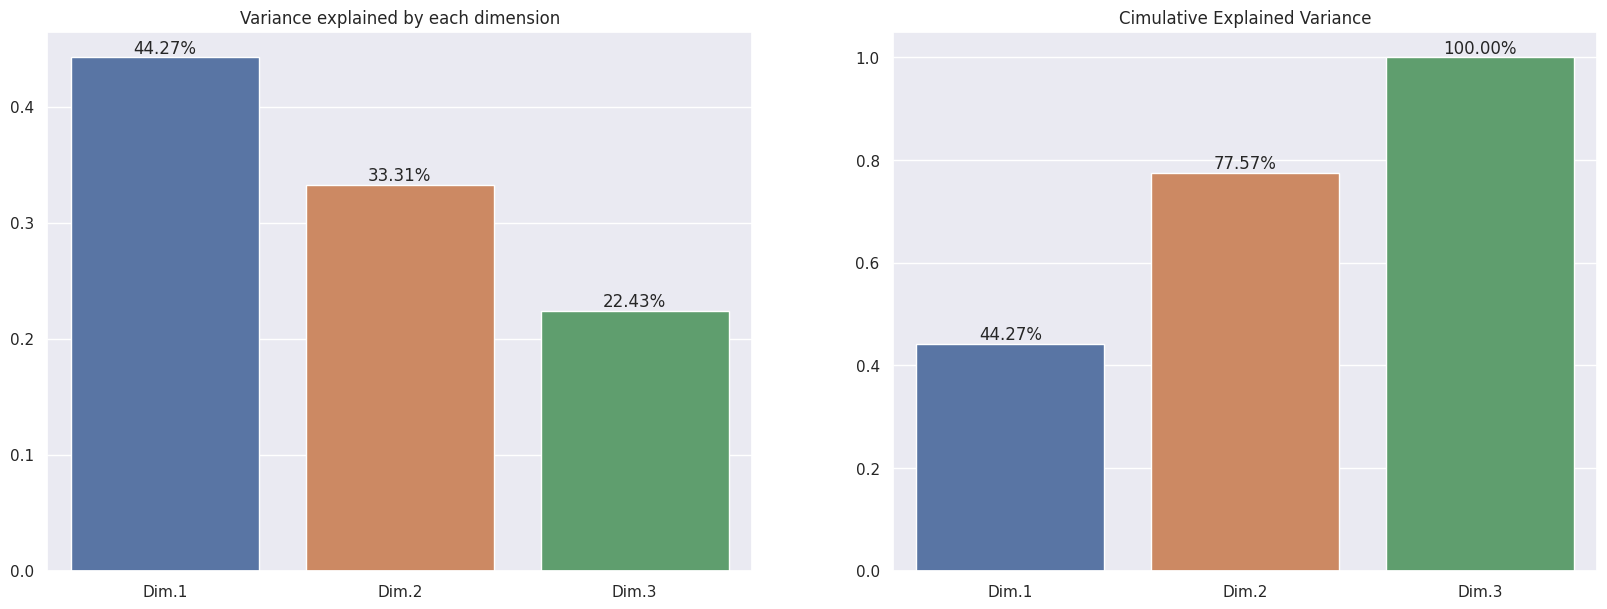

In [26]:
variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)




fig, ax = plt.subplots(1,2,figsize=(20,7))
sns.barplot(x=["Dim." + str(dim) for dim in np.arange(1, len(cumulative_variance) + 1)], y=variance,ax=ax[0])
ax[0].bar_label(ax[0].containers[0], labels=[f'{val:.2%}' for val in variance], label_type='edge')
ax[0].set_title("Variance explained by each dimension")


sns.barplot(x=["Dim." + str(dim) for dim in np.arange(1, len(cumulative_variance) + 1)], y=cumulative_variance,ax=ax[1])
ax[1].bar_label(ax[1].containers[0], labels=[f'{val:.2%}' for val in cumulative_variance], label_type='edge')
ax[1].set_title("Cimulative Explained Variance")


We can deduce that we must consider 2 PCA components are enough to explain 75% of the variance of the data and therefore 75% of the information.

### Individual Factor Map

In [27]:
def pca_plot_individuals(pca,data=df,pca_variables=numerical_columns,n_pca=df.shape[0],n_plot=df.shape[0],inverse=False,markers=False,edgecolor='black',dim1=1 , dim2=2,size=(10,8),to_c = True,c_column=None,is_categorical=False,is_numerical=False):
    if n_pca < n_plot:
        n_plot = n_pca
        print("Number of individuas to plot are higher that individuals considered in the LDA")

    if inverse:
        inverse= -1
    else:
        inverse = +1

    if to_c  and c_column:
        if is_categorical:
            is_numerical=False
        else:
            is_numerical=True
        

    subset_df = data.sample(n_pca)



    C= pca.transform(subset_df[pca_variables])
    C= pd.DataFrame(C,index=subset_df.index,columns=['Dim.' + str(dim) for dim in np.arange(1, len(pca_variables) + 1)])

    plt.figure(figsize=size)
    C_sample = C.sample(n_plot)
    names=C_sample.index
    
    if to_c and c_column:
        c= subset_df.loc[C_sample.index,c_column]
        if is_categorical:
            scatter = sns.scatterplot(x=C_sample[C_sample.columns[dim1-1]],y=inverse*C_sample[C_sample.columns[dim2-1]],hue=c,edgecolor=edgecolor)
        elif is_numerical:
            scatter = plt.scatter(x=C_sample[C_sample.columns[dim1-1]],y=inverse*C_sample[C_sample.columns[dim2-1]],c=c,edgecolor=edgecolor)
            cbar=plt.colorbar(scatter)
            cbar.ax.set_title(c_column)
    else : 
        scatter = sns.scatterplot(x=C_sample[C_sample.columns[dim1-1]],y=inverse*C_sample[C_sample.columns[dim2-1]],edgecolor=edgecolor)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    if markers:
        for x,y,nom in zip(C_sample.iloc[:,0],C_sample.iloc[:,1],names):
            plt.text(x,y,nom)
    plt.title(f"Individual plot of PCA in dimensions {dim1} and {dim2}")
    plt.xlabel(f"dim{dim1} with inertia {pca.explained_variance_ratio_[dim1-1]:.2%}")
    plt.ylabel(f"dim{dim2} with inertia {pca.explained_variance_ratio_[dim2-1]:.2%}")


    plt.show()
        

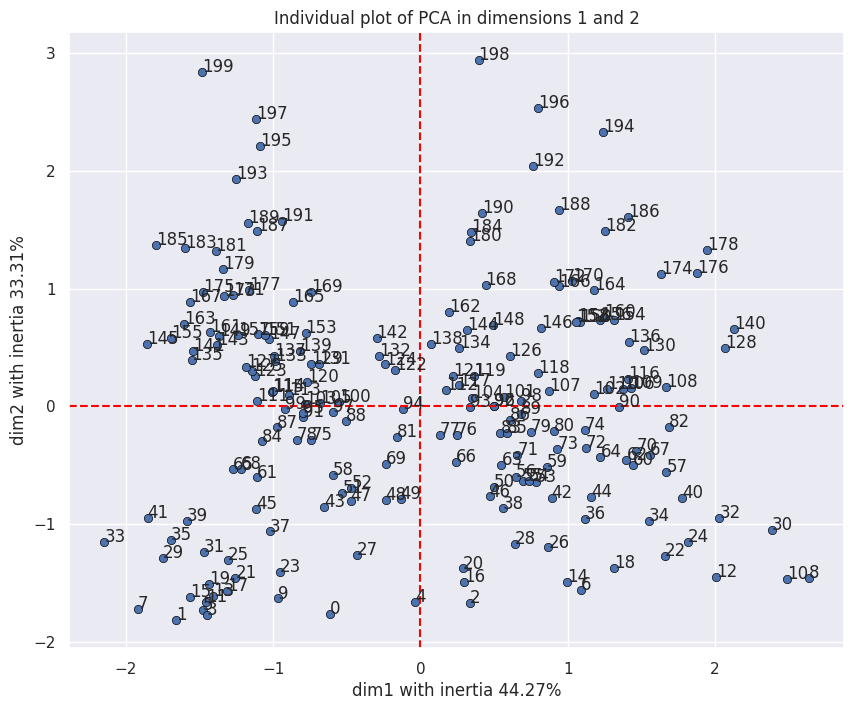

In [28]:
pca_plot_individuals(pca,data=df_scaled,to_c=False,markers=True,size=(10,8))

We can see that we can more or less distinguish 5 clusters in the individual factor map. However, we can see that the clusters are not well separated.

### Variable Factor Map

In [29]:
def plot_pca_varcor(pca,inverse=False,data=df[numerical_columns],Legend=True,markers=True,plot_variables = numerical_columns,dim1 = 1 , dim2=2,size=(12,12)):
    if inverse:
        inverse= -1
    else:
        inverse = +1
    

    conponents = pd.DataFrame(pca.components_,columns=data.columns,index=range(0,len(pca.components_)))
    conponents = conponents[plot_variables]
    coord1 = inverse*conponents.iloc[dim1-1,:] * np.sqrt(pca.explained_variance_[dim1-1])
    coord2 = inverse*conponents.iloc[dim2-1,:] * np.sqrt(pca.explained_variance_[dim2-1])
    couleurs = plt.cm.get_cmap('tab20',len(data.columns))
    fig=plt.figure(figsize=size)
    ax=fig.add_subplot(1,1,1)
    legend = []
    head_length=0.05
    for i,j,nom,couleur in zip(coord1,coord2,plot_variables,couleurs.colors):
        legend.append(nom)
        if i >0 and j >0 :
            angle = np.arctan(j/i)
        elif i<0 and j >0 :
            angle = np.pi + np.arctan(j/i)
        elif i>0 and j <0 :
            angle =  np.arctan(j/i)
        elif i<0 and j <0 :
            angle = np.arctan(j/i)
        elif j == 0:
            angle = 0
        elif i == 0:
            angle = np.pi/2
        if markers:
            plt.text(i,j,nom,fontsize=15)
        
        plt.arrow(0,0,i-head_length * np.cos(angle),j-head_length * np.sin(angle),color=couleur,head_width=0.05,label=nom,head_length=0.05)

    plt.axis((-1.2,1.2,-1.2,1.2))
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    c=plt.Circle((0,0),radius=1,color='blue',fill=False)


    plt.xlabel(f"dim{dim1} with inertia {pca.explained_variance_ratio_[dim1-1]:.2%}")
    plt.ylabel(f"dim{dim2} with inertia {pca.explained_variance_ratio_[dim2-1]:.2%}")
    plt.title(f"Variable correlation in dimensions {dim1} and {dim2}")
    ax.add_patch(c)
    if Legend:
       plt.legend(plot_variables,loc='best')
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.show()



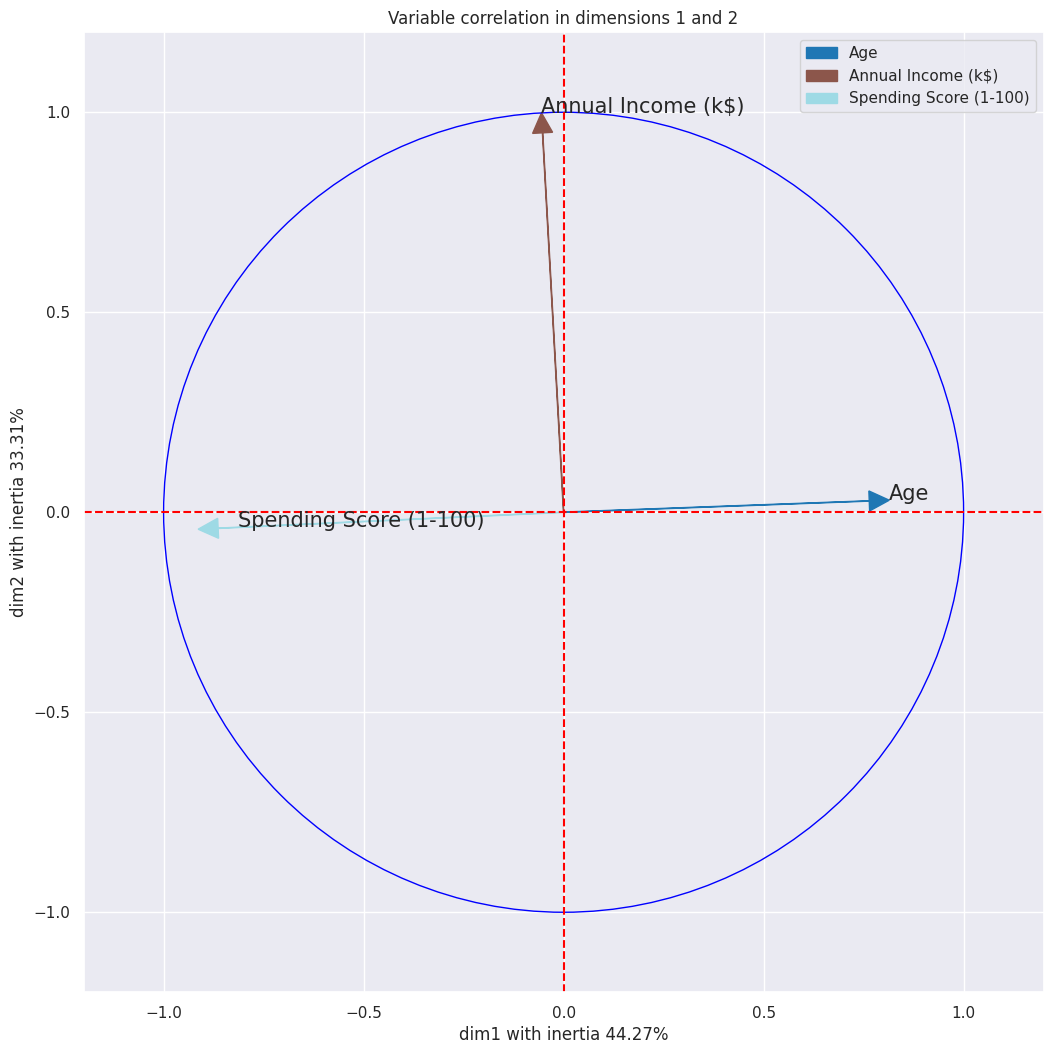

In [30]:
plot_pca_varcor(pca,data=df_scaled[numerical_columns],markers=True,size=(12,12))

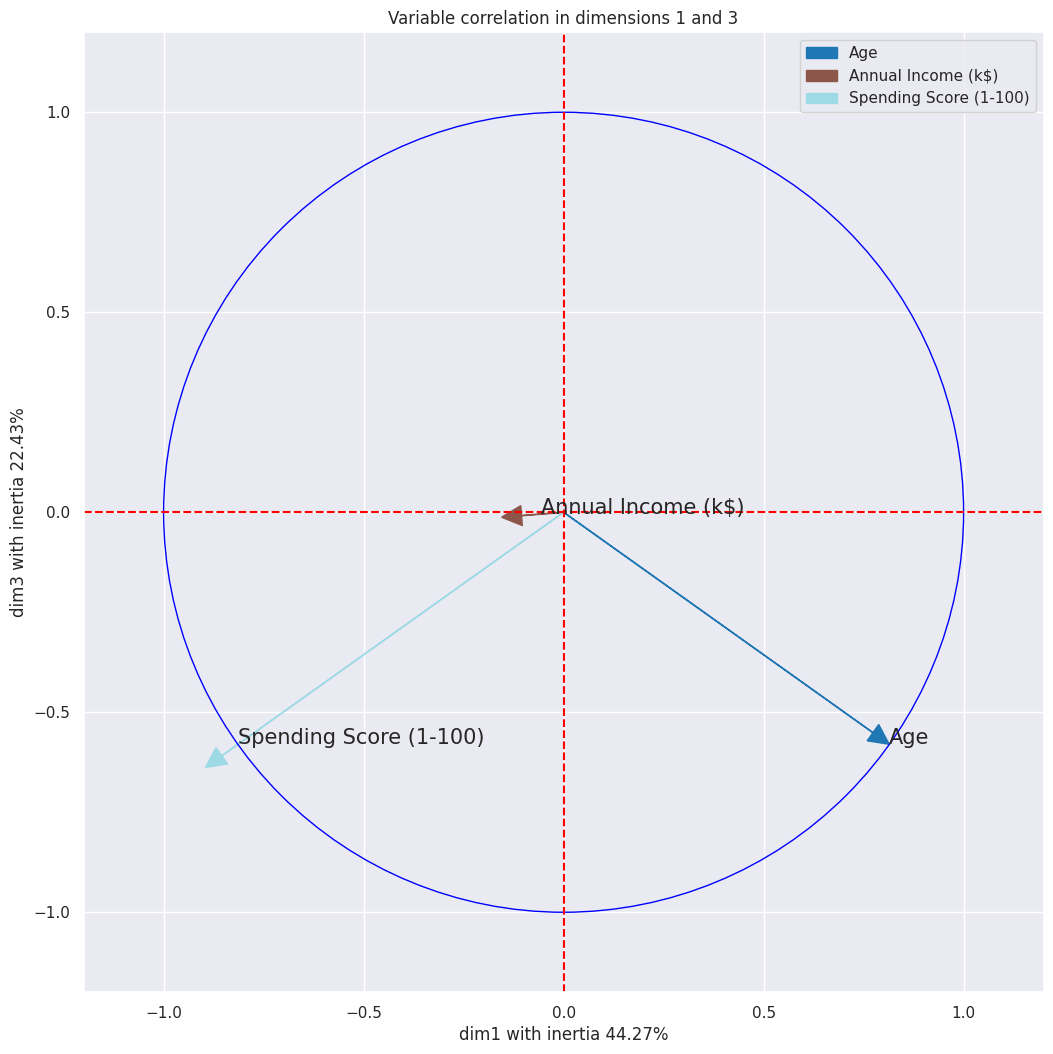

In [31]:
plot_pca_varcor(pca,markers=True,size=(12,12),dim1=1,dim2=3)

Let's Perform the Clustering

# 📈Clustering📈

## K-Means

### Number of Clusters

In [32]:
Kmeans_columns = ['Annual Income (k$)','Spending Score (1-100)']

Before applying the K-Means algorithm, we will try to find the optimal number of clusters using the **`R-squared`** method, the **`Semi-Partial R-square`** method, the **`Calinski_Jarabasz_score`** method and the **`silhouette_score`** method.

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

def nb_cluster(data, clust_variables, nb_cluster_min, nb_cluster_max=10, size=(10, 8)):
    dict_result = {}

    # Create series outside the loop
    dict_result['Inertia'] = pd.Series(index=range(nb_cluster_min, nb_cluster_max + 1))
    dict_result['Calinski-Harabasz'] = pd.Series(index=range(nb_cluster_min, nb_cluster_max + 1))
    dict_result['Silhouette'] = pd.Series(index=range(nb_cluster_min, nb_cluster_max + 1))
    dict_result['Semi-Partial R Square'] = pd.Series(index=range(nb_cluster_min + 1, nb_cluster_max + 1))  # Starts from i=2

    for i in range(nb_cluster_min, nb_cluster_max + 1):
        kmeans = KMeans(n_clusters=i, n_init=100).fit(data[clust_variables])

        # Inertia
        dict_result['Inertia'].loc[i] = kmeans.inertia_

        # Calinski-Harabasz
        if i > 1:
            dict_result['Calinski-Harabasz'].loc[i] = calinski_harabasz_score(data[clust_variables], kmeans.labels_)

        # Silhouette
        if i > 1:
            dict_result['Silhouette'].loc[i] = silhouette_score(data[clust_variables], kmeans.labels_)

        # Semi-Partial R Square
        if i > nb_cluster_min:
            dict_result['Semi-Partial R Square'].loc[i] = -dict_result['Inertia'].loc[i] + dict_result['Inertia'].loc[i - 1]

    return dict_result


result = nb_cluster(df, Kmeans_columns ,nb_cluster_min=2, nb_cluster_max=10)


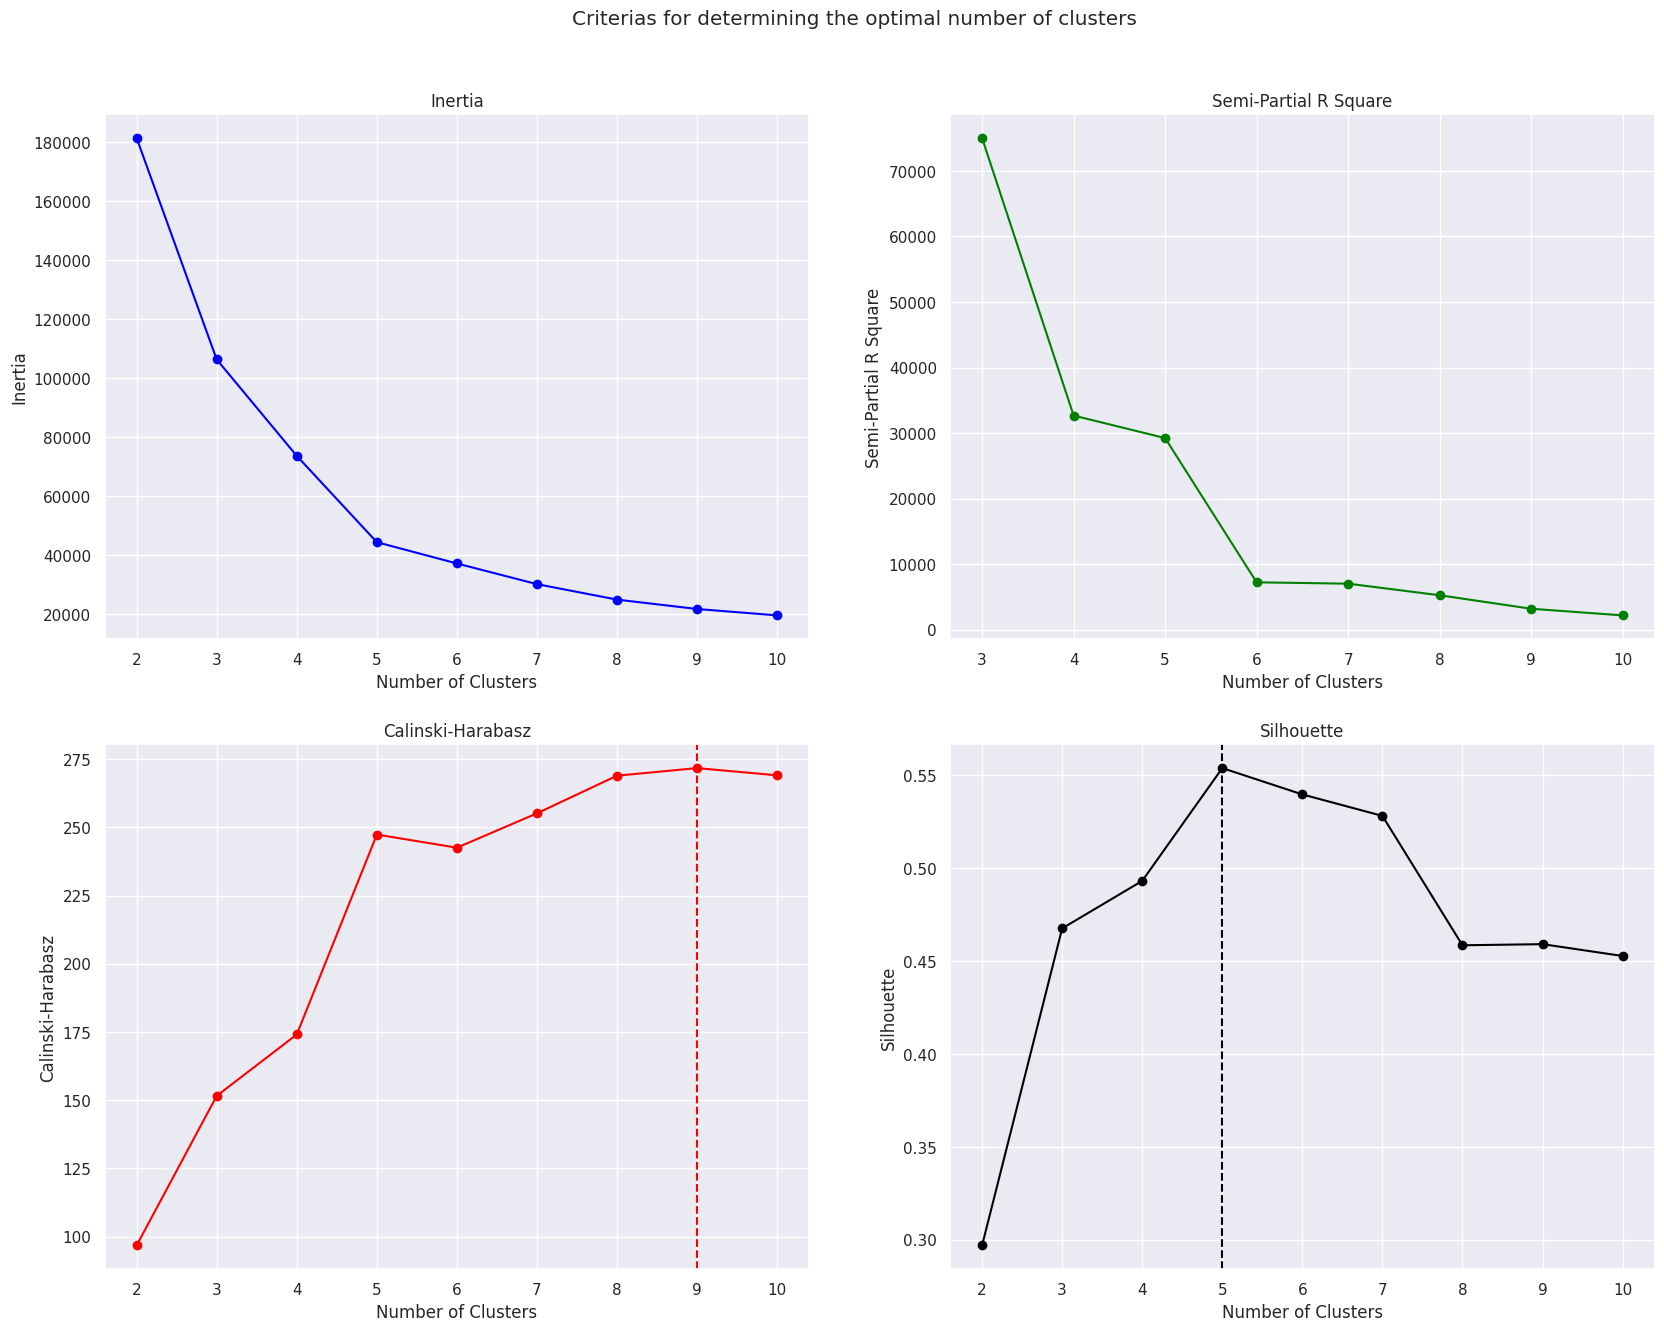

In [34]:
def plot_nb_cluster(dict_result, size=(20, 15)):
    fig, ax = plt.subplots(2, 2, figsize=size)

    # Inertia
    ax[0, 0].plot(dict_result['Inertia'], marker='o', color='blue')
    ax[0, 0].set_title('Inertia')
    ax[0, 0].set_xlabel('Number of Clusters')
    ax[0, 0].set_ylabel('Inertia')

    # Semi-Partial R Square
    ax[0, 1].plot(dict_result['Semi-Partial R Square'], marker='o', color='green')
    ax[0, 1].set_title('Semi-Partial R Square')
    ax[0, 1].set_xlabel('Number of Clusters')
    ax[0, 1].set_ylabel('Semi-Partial R Square')

    # Calinski-Harabasz with vertical dashed line
    calinski_values = dict_result['Calinski-Harabasz']
    max_calinski_index = calinski_values.idxmax()
    ax[1, 0].plot(calinski_values, marker='o', color='red')
    ax[1, 0].axvline(x=max_calinski_index, linestyle='--', color='red', label='Max Calinski')
    ax[1, 0].set_title('Calinski-Harabasz')
    ax[1, 0].set_xlabel('Number of Clusters')
    ax[1, 0].set_ylabel('Calinski-Harabasz')

    # Silhouette with vertical dashed line
    silhouette_values = dict_result['Silhouette']
    max_silhouette_index = silhouette_values.idxmax()
    ax[1, 1].plot(silhouette_values, marker='o', color='black')
    ax[1, 1].axvline(x=max_silhouette_index, linestyle='--', color='black')
    ax[1, 1].set_title('Silhouette')
    ax[1, 1].set_xlabel('Number of Clusters')
    ax[1, 1].set_ylabel('Silhouette')

    plt.suptitle('Criterias for determining the optimal number of clusters', y=0.95)
    plt.show()

# Example usage
plot_nb_cluster(result, size=(20, 15))


> We can see that the optimal number of clusters is $5$ according to the **`R-squared`** and the **`Silhouette`** method,  3 and 5 according to the **`Semi-Partial R-square`** method and 9 for the **`Calinski_Jarabasz_score`** method.

### K-Means Clustering

Let's apply the K-Means algorithm with $5$ clusters.

In [37]:
Final_Kmeans = KMeans(n_clusters=5, n_init=100,random_state=1).fit(df_scaled[Kmeans_columns])
df_scaled['Cluster'] = Final_Kmeans.labels_
df['Cluster'] = Final_Kmeans.labels_

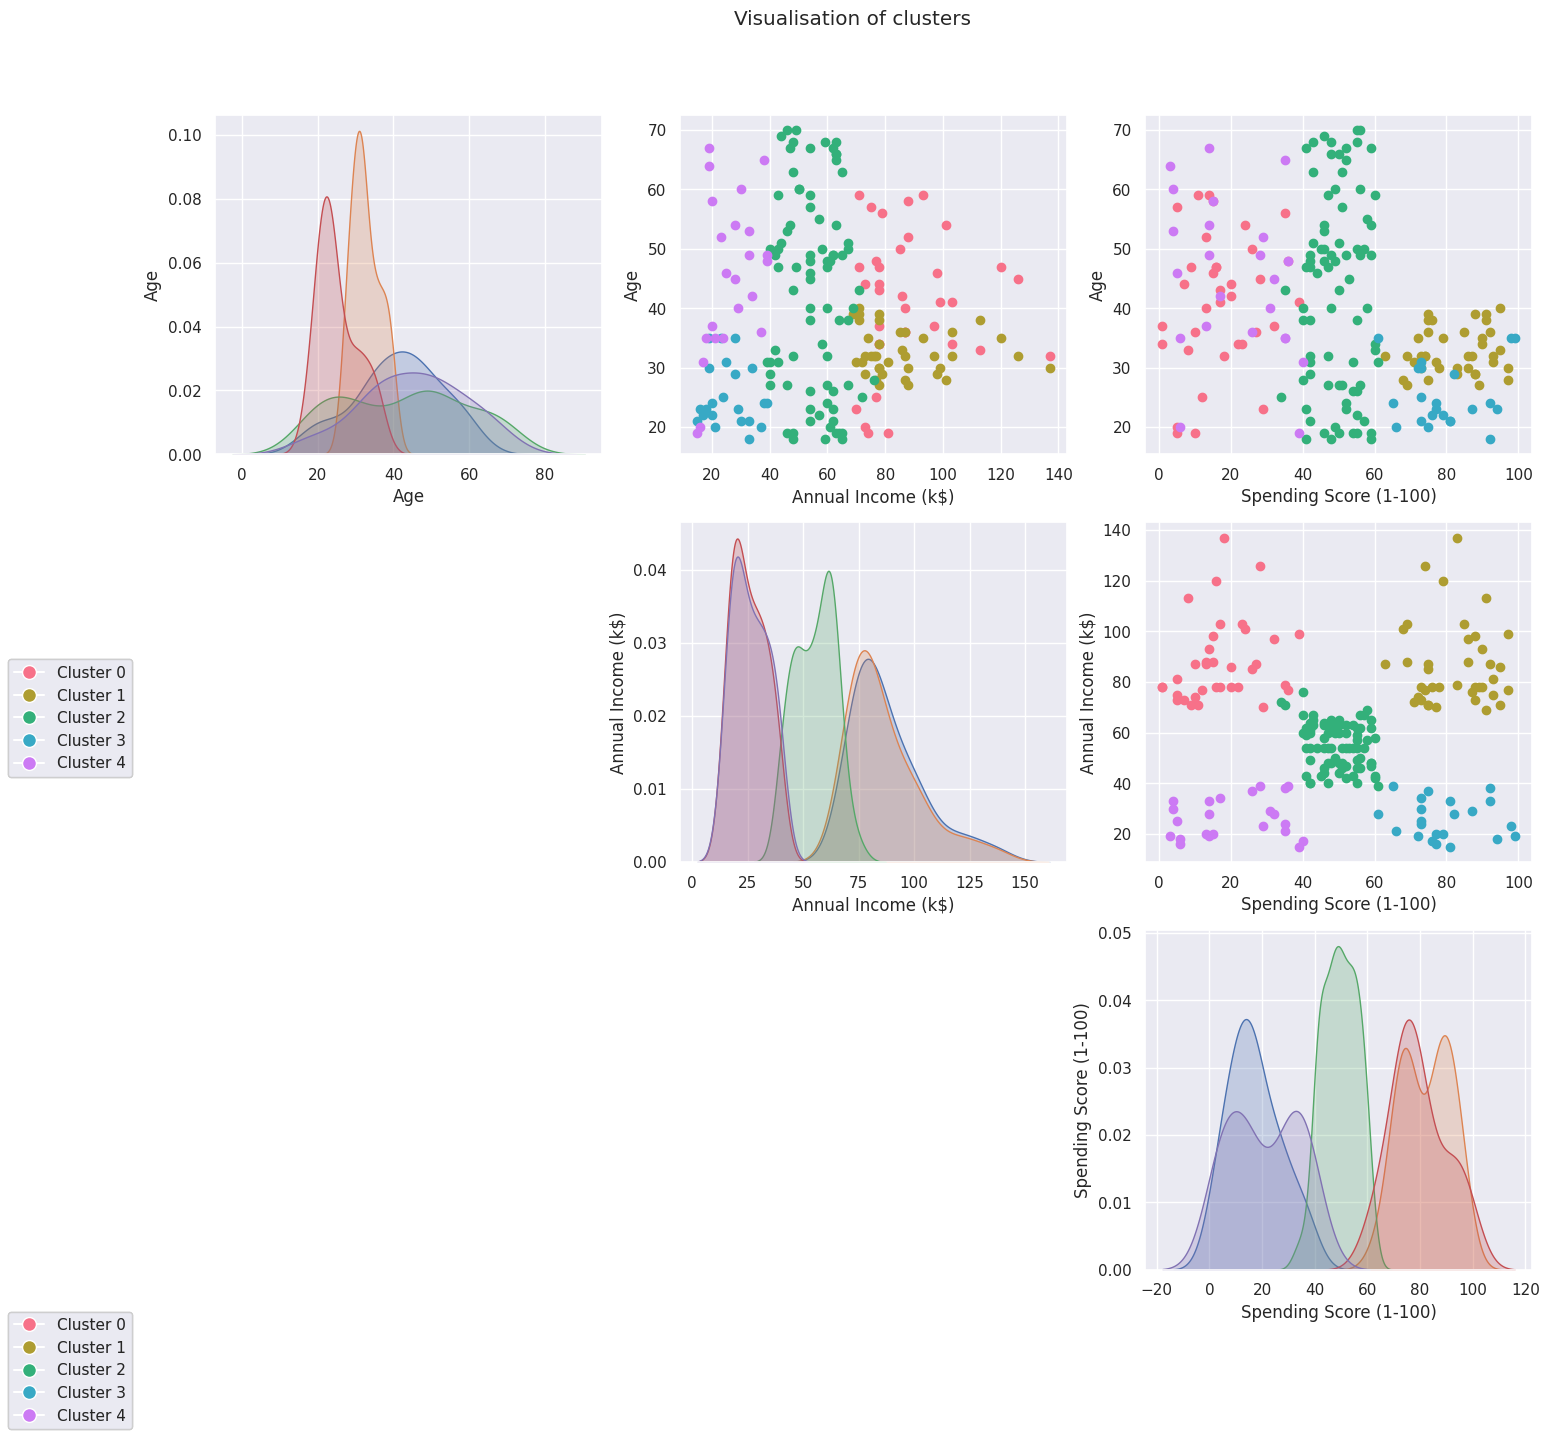

In [38]:
from matplotlib.lines import Line2D

def plot_cluster(data, kmeans_result, plot_variables, size=(12, 12),all='Upper'):
    data['Cluster'] = kmeans_result.labels_
    nb_col = len(plot_variables)
    fig, axes = plt.subplots(nb_col, nb_col, figsize=size)

    # Custom color palette for clusters
    cluster_palette = sns.color_palette('husl', n_colors=len(data['Cluster'].unique()))
    clusters = np.sort(data['Cluster'].unique())

    if all == 'Upper' :
        for i in range(nb_col):
            for j in range(nb_col):
                if i == j:
                    for cluster_label in clusters:
                        sns.kdeplot(data=data[data['Cluster'] == cluster_label], x=plot_variables[i],
                                    ax=axes[i, j], label=f'Cluster {cluster_label}', fill=True)
                elif i < j:
                    for cluster_label in clusters:
                        axes[i, j].scatter(x=data[data['Cluster'] == cluster_label][plot_variables[j]],
                                        y=data[data['Cluster'] == cluster_label][plot_variables[i]],
                                        c=[cluster_palette[cluster_label]], label=f'Cluster {cluster_label}')
                else:
                    axes[i, j].axis('off')  # Ne rien afficher dans la partie supérieure
                axes[i, j].set_xlabel(f"{plot_variables[j]}")
                axes[i, j].set_ylabel(f"{plot_variables[i]}")

            # Create custom legend with points
            custom_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_palette[i], markersize=10,
                                    label=f'Cluster {i}') for i in clusters]

            # Add a common legend outside the subplots
            fig.legend(handles=custom_legend, loc='center left')
            fig.legend(handles=custom_legend, loc='lower left')
    elif all =='Lower':    
        for i in range(nb_col):
            for j in range(nb_col):
                if i == j:
                    for cluster_label in clusters:
                        sns.kdeplot(data=data[data['Cluster'] == cluster_label], x=plot_variables[i],
                                    ax=axes[i, j], label=f'Cluster {cluster_label}', fill=True)
                elif i > j:
                    for cluster_label in clusters:
                        axes[i, j].scatter(x=data[data['Cluster'] == cluster_label][plot_variables[j]],
                                        y=data[data['Cluster'] == cluster_label][plot_variables[i]],
                                        c=[cluster_palette[cluster_label]], label=f'Cluster {cluster_label}')
                else:
                    axes[i, j].axis('off')  # Ne rien afficher dans la partie supérieure
                axes[i, j].set_xlabel(f"{plot_variables[j]}")
                axes[i, j].set_ylabel(f"{plot_variables[i]}")

            # Create custom legend with points
            custom_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_palette[i], markersize=10,
                                    label=f'Cluster {i}') for i in clusters]

            # Add a common legend outside the subplots
            fig.legend(handles=custom_legend, loc='center right')
            fig.legend(handles=custom_legend, loc='upper right')
    elif all == True:
        for i in range(nb_col):
            for j in range(nb_col):
                if i == j:
                    for cluster_label in clusters:
                        sns.kdeplot(data=data[data['Cluster'] == cluster_label], x=plot_variables[i],
                                    ax=axes[i, j], label=f'Cluster {cluster_label}', fill=True)
                elif i != j:
                    for cluster_label in clusters:
                        axes[i, j].scatter(x=data[data['Cluster'] == cluster_label][plot_variables[j]],
                                        y=data[data['Cluster'] == cluster_label][plot_variables[i]],
                                        c=[cluster_palette[cluster_label]], label=f'Cluster {cluster_label}')
                else:
                    axes[i, j].axis('off')
                axes[i, j].set_xlabel(f"{plot_variables[j]}")
                axes[i, j].set_ylabel(f"{plot_variables[i]}")
        # Create custom legend with points
        custom_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_palette[i], markersize=10,
                                label=f'Cluster {i}') for i in clusters]

        # Add a common legend outside the subplots
        fig.legend(handles=custom_legend)

    # Adjust layout
    fig.suptitle('Visualisation of clusters', y=0.95)
    plt.show()

# Exemple d'utilisation:
plot_cluster(df, Final_Kmeans, numerical_columns, size=(17, 15),all='Upper')


> The 5 clusters are well separated and we can easily distinguish them.
>
> Cluster $0$ : The customers of this cluster have a **Hight** Annual Income and a **Low** Spending Score, and are middle Aged.
>
> Cluster $1$ : The customers of this cluster have a **Hight** Annual Income and a **High** Spending Score.
> 
> Cluster $2$ : The customers of this cluster have a **Middle** Annual Income and a **Middle** Spending Score, and are old.
>
> Cluster $3$ : The customers of this cluster have a **Low** Annual Income and a **High** Spending Score, and are young.
> 
> Cluster $4$ : The customers of this cluster have a **Low** Annual Income and a **Low** Spending Score, and have different ages.


> In order to better visualize the clusters, we will apply a Linear Discriminant Analysis (LDA) to our data.

# Linear Discriminant Analysis

In [39]:
df_kmeans = df_scaled.copy()

In [40]:
df_lda = df_kmeans[numerical_columns+['Cluster']]

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

target = df_lda['Cluster']
features = df_lda.drop('Cluster', axis=1)
method = LinearDiscriminantAnalysis()

X_train, X_test ,Y_train,Y_test = train_test_split(features, target, test_size=0.5)
lda = method.fit(X_train, Y_train)

## LDA individual factor map

In [41]:
def lda_plot_individuals(lda,X_train=X_train,Y_train=Y_train,n_lda=X_train.shape[0],n_plot=X_train.shape[0],inverse=False,markers=False,edgecolor='black',dim1 = 1 , dim2=2,size=(10,8),to_c = True,c_column=None,is_categorical=False,is_numerical=False):
    if n_lda < n_plot:
        n_plot = n_lda

    if is_categorical:
        is_numerical=False
    else:
        is_numerical=True
    

    subset_df = X_train.sample(n_lda).sort_index()

    if inverse:
        inverse= -1
    else:
        inverse = +1
    C= lda.transform(subset_df)
    C= pd.DataFrame(C,index=subset_df.index,columns=['Dim.' + str(dim) for dim in np.arange(1, C.shape[1] + 1)])
    Y_train = Y_train.loc[C.index,]
    C['Cluster']=Y_train
    plt.figure(figsize=size)
    C_sample = C.sample(n_plot).sort_index()
    names=C_sample.index
    if to_c and c_column  and is_numerical: 
        c= subset_df.loc[C_sample.index,c_column]
    elif to_c and c_column and is_categorical:
        c= C_sample['Cluster']
    if is_categorical:
        scatter = sns.scatterplot(data=C_sample,x='Dim.' + str(dim1),y='Dim.' + str(dim2),hue='Cluster',edgecolor=edgecolor,palette='tab20')
    elif is_numerical:
        scatter = plt.scatter(x=C_sample['Dim.' + str(dim1)],y=inverse*C_sample['Dim.' + str(dim2)],c=c,edgecolor=edgecolor)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    if markers:
        for x,y,nom in zip(C_sample.iloc[:,0],C_sample.iloc[:,1],names):
            plt.text(x,y,nom)
    if to_c and is_numerical :
        cbar=plt.colorbar(scatter)
        cbar.ax.set_title(c_column)
    plt.title(f"Individual plot of LDA in dimensions {dim1} and {dim2}")
    plt.xlabel(f"dim{dim1} with inertia {lda.explained_variance_ratio_[dim1-1]:.2%}")
    plt.ylabel(f"dim{dim2} with inertia {lda.explained_variance_ratio_[dim2-1]:.2%}")


    plt.show()

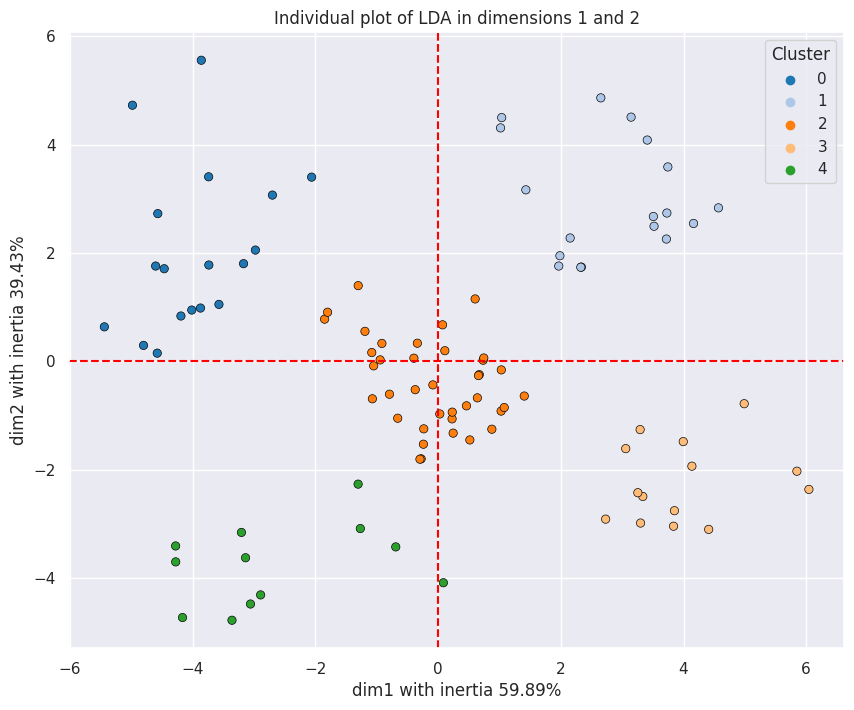

In [42]:
lda_plot_individuals(lda,to_c=True,markers=False,c_column='Cluster',size=(10,8),is_categorical=True)

> We notice that the clusters are well separated and we can easily distinguish them in the case of the LDA individual factor map. In order to see the differences between the clusters, we will plot the LDA variables factor map with the different clusters.

In [43]:
def compute_var_cor(df1,df2):
    correlation_matrix = pd.DataFrame(np.zeros((df1.shape[1], df2.shape[1])),columns=df2.columns,index=df1.columns)


    for i in range(df1.shape[1]):  # Pour chaque colonne de matrix1
        for j in range(df2.shape[1]):  # Pour chaque colonne de matrix2
            correlation_matrix.iloc[i, j] = np.corrcoef(df1.iloc[:, i], df2.iloc[:, j])[0, 1]
    return correlation_matrix

In [44]:
def lda_plot_varcor(lda,X_train=X_train,Y_train=Y_train,data=df,n_lda = X_train.shape[0] ,lda_variables=numerical_columns,inverse=False,Legned=True,markers=True,plot_variables = numerical_columns,dim1 = 1 , dim2=2,size=(12,12)):
    def angle_(i,j) : 
        if i >0 and j >0 :
            angle = np.arctan(j/i)
        elif i<0 and j >0 :
            angle = np.pi + np.arctan(j/i)
        elif i>0 and j <0 :
            angle =  np.arctan(j/i)
        elif i<0 and j <0 :
            angle = -np.arctan(i/j) -np.pi/2
        elif i==0 :
            angle = 0 + (j/abs(j))*np.pi/2
        elif j==0 :
            if i > 0 :
                angle = 0
            else:
                angle = np.pi
        return angle
            
    
    
    
    subset_df = X_train.sample(n_lda)

    if inverse:
        inverse= -1
    else:
        inverse = +1

    C= lda.transform(subset_df)
    C= pd.DataFrame(C,index=subset_df.index,columns=['Dim.' + str(dim) for dim in np.arange(1, X_train.shape[1] + 1)])
    initial_data = data.loc[C.index,lda_variables]
    matrix_cor = compute_var_cor(C,initial_data)
    matrix_cor = matrix_cor[plot_variables]

    coord1 = inverse*matrix_cor.iloc[dim1-1,:] 
    coord2 = inverse*matrix_cor.iloc[dim2-1,:]
    couleurs = plt.cm.get_cmap('tab20',len(data.columns))
    fig=plt.figure(figsize=size)
    ax=fig.add_subplot(1,1,1)
    legend = []
    head_length=0.05
    for i,j,nom,couleur in zip(coord1,coord2,plot_variables,couleurs.colors):
        legend.append(nom)
        angle = angle_(i,j)

        if markers:
            plt.text(i,j,nom,fontsize=15)
        
        plt.arrow(0,0,i-head_length * np.cos(angle),j-head_length * np.sin(angle),color=couleur,head_width=0.05,label=nom,head_length=0.05)

    plt.axis((-1.2,1.2,-1.2,1.2))
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    c=plt.Circle((0,0),radius=1,color='blue',fill=False)


    plt.xlabel(f"dim{dim1} with inertia {pca.explained_variance_ratio_[dim1-1]:.2%}")
    plt.ylabel(f"dim{dim2} with inertia {pca.explained_variance_ratio_[dim2-1]:.2%}")
    plt.title(f"Linear Discriminant Analysis : Variable correlation in dimensions {dim1} and {dim2}")
    ax.add_patch(c)
    if Legned:
        plt.legend(plot_variables,loc='best')
    plt.show()


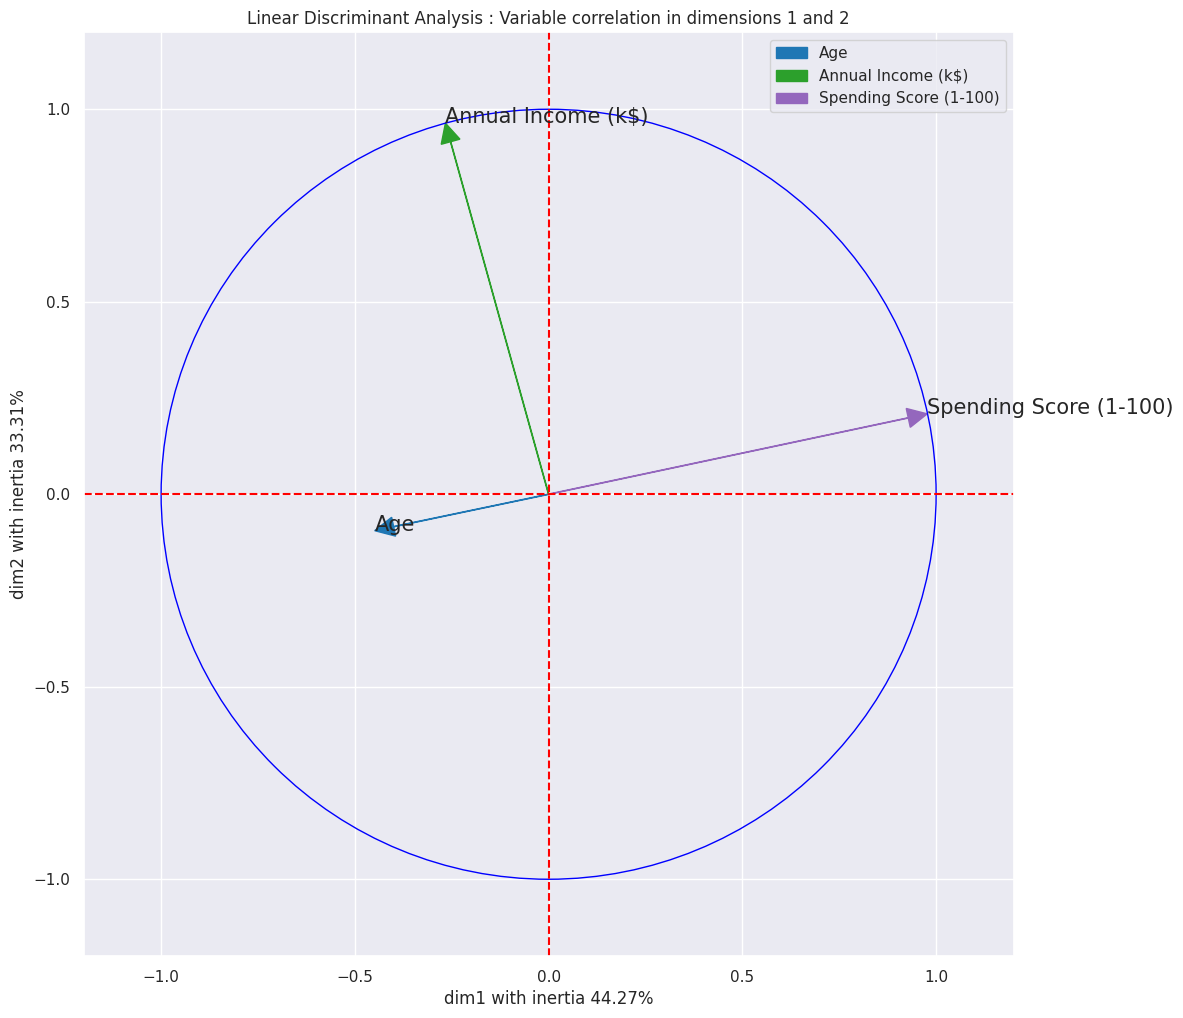

In [45]:
lda_plot_varcor(lda,X_train=X_train,Y_train=Y_train,data=df,lda_variables=numerical_columns,inverse=False,Legned=True,markers=True,plot_variables = numerical_columns,dim1 = 1 , dim2=2,size=(12,12))

Let's see if LDA can predict which cluster a customer belongs to.

## Prediction using LDA

In [46]:
import time

method = LinearDiscriminantAnalysis()
ts = time.time()
method.fit(X_train, Y_train)
scoreLDA = method.score(X_test, Y_test)
ypredLDA = method.predict(X_test)
te = time.time()

Score : 0.980000, time running : 0 secondes


Text(0.5, 1.0, 'Confusion matrix of LDA')

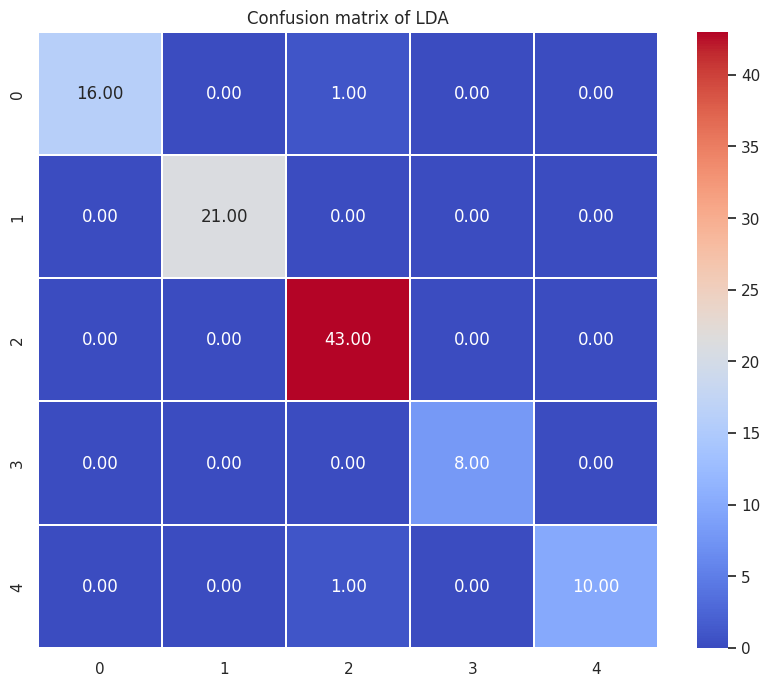

In [47]:
from sklearn.metrics import confusion_matrix
print("Score : %f, time running : %d secondes" %(scoreLDA, te - ts))
labels=np.unique(Y_test)
plt.figure(figsize=(10,8))
confusion_matrix_=pd.DataFrame(confusion_matrix(Y_test, ypredLDA),index=labels,columns=labels)
sns.heatmap(confusion_matrix_,annot=True,cmap='coolwarm',linewidths=0.1,fmt=".2f")
plt.title("Confusion matrix of LDA")

We can see that we have a $90\%$ accuracy using LDA to predict the clusters of the customers.

The Confusion Matrix shows that we have perfetc results.